# heatmap

In [68]:
%load_ext autoreload
%autoreload 2

from os.path import expanduser
from itertools import islice
from random import seed, sample

from tqdm.notebook import tqdm as log_progress
from scipy.special import softmax
from matplotlib import pyplot as plt
from seaborn import heatmap

from razdel import sentenize, tokenize
from corus import load_lenta

from slovnet.io import (
    load_gz_lines,
    parse_jl
)
from slovnet.markup import (
    SyntaxMarkup,
    show_syntax_markup
)
from slovnet import Syntax

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [65]:
path = expanduser('~/proj/naeval/data/syntax/dataset/news.jl.gz')
lines = load_gz_lines(path)
items = parse_jl(lines)
targets = [SyntaxMarkup.from_json(_) for _ in items]

In [66]:
syntax = Syntax('slovnet_syntax_news_v1.tar')
preds = []
for markup in log_progress(targets):
    markup = next(syntax([markup.words]))
    preds.append(markup)

In [103]:
indexes = []
for index, (target, pred) in enumerate(zip(targets, preds)):
    target = [_.head_id for _ in target.tokens]
    pred = [_.head_id for _ in pred.tokens]
    if target != pred and len(target) < 20:
        indexes.append(index)

In [144]:
indexes = iter(indexes)

---


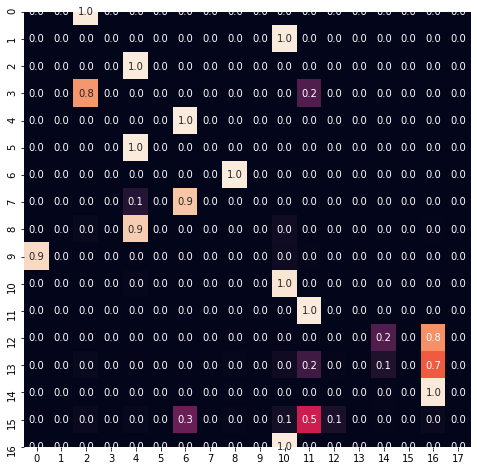

In [154]:
index = next(indexes)
show_syntax_markup(targets[index])
print('---')
show_syntax_markup(preds[index])
head_id = syntax.model.head_ids[index].squeeze()
head_id = softmax(head_id, -1)
fig, ax = plt.subplots()
heatmap(head_id, annot=True, fmt='0.1f', cbar=False, ax=ax)
fig.set_size_inches(8, 8)

# bench

In [ ]:
#  3.5s segment

#  1.3s encoder item (shape, vocab)
#  0.3s encoder input (numpy batch)

#  2.1s model emb
# 17.1s model encoder
#  0.9s model head
#  4.2s model rel + head decoder

#  0.6s decoder

In [1]:
%load_ext autoreload
%autoreload 2

from os.path import expanduser
from itertools import islice

from tqdm.notebook import tqdm as log_progress

from corus import load_lenta

from slovnet import Syntax

In [2]:
path = expanduser('~/proj/corus-data/lenta-ru-news.csv.gz')
records = load_lenta(path)
texts = [_.text for _ in islice(records, 1000)]

In [3]:
%%time
chunk = []
for text in texts:
    for sent in sentenize(text):
        words = [_.text for _ in tokenize(sent.text)]
        chunk.append(words)

CPU times: user 3.81 s, sys: 43 ms, total: 3.85 s
Wall time: 3.87 s


In [27]:
syntax = Syntax('slovnet_syntax_news_v1.tar')
markups = list(log_progress(syntax(chunk)))

# syntax

In [1]:
# >>> from ipymarkup import show_dep_ascii_markup as show_markup
# >>> from razdel import sentenize, tokenize
# >>> from slovnet import Syntax

# >>> chunk = []
# >>> for sent in sentenize(text):
# >>>     tokens = [_.text for _ in tokenize(sent.text)]
# >>>     chunk.append(tokens)
# >>> chunk[:1]
# [['Европейский', 'союз', 'добавил', 'в', 'санкционный', 'список', 'девять', 'политических', 'деятелей', 'из', 'самопровозглашенных', 'республик', 'Донбасса', '—', 'Донецкой', 'народной', 'республики', '(', 'ДНР', ')', 'и', 'Луганской', 'народной', 'республики', '(', 'ЛНР', ')', '—', 'в', 'связи', 'с', 'прошедшими', 'там', 'выборами', '.']]

# >>> morph = Syntax('slovnet_syntax_news_v1.tar')

# >>> markup = next(morph(chunk))

# # Convert CoNLL-style format to source, target indices
# >>> words, deps = [], []
# >>> for token in markup.tokens:
# >>>     words.append(token.text)
# >>>     source = int(token.head_id) - 1
# >>>     target = int(token.id) - 1
# >>>     if source > 0 and source != target:  # skip root, loops
# >>>         deps.append([source, target, token.rel])
# >>> show_markup(words, deps)


In [15]:
from itertools import islice
from slovnet.io import (
    load_gz_lines,
    parse_jl
)
from slovnet.markup import SyntaxMarkup

lines = load_gz_lines('/Users/alexkuk/proj/naeval/data/syntax/dataset/news.jl.gz')
items = parse_jl(lines)
markups = (SyntaxMarkup.from_json(_) for _ in items)
markups = list(islice(markups, 1000))

In [2]:
# from slovnet.encoders.syntax import SyntaxTrainEncoder
# encoder = SyntaxTrainEncoder(
#     words_vocab, shapes_vocab, rels_vocab,
#     batch_size=4
# )
# batches = list(encoder(markups))

In [3]:
# batch = batches[0]
# input, target = batch

# pred = model(input.word_id, input.shape_id, input.pad_mask, target.mask, target.head_id)
# pred.head_id = model.head.decode(pred.head_id, target.mask)
# pred.rel_id = model.rel.decode(pred.rel_id, target.mask)

In [1]:
%load_ext autoreload
%autoreload 2

import torch
torch.set_grad_enabled(False)

from navec import Navec

from slovnet.const import PAD, CPU
from slovnet.shape import SHAPES
from slovnet.vocab import Vocab
from slovnet.model.emb import (
    NavecEmbedding,
    Embedding
)
from slovnet.model.syntax import (
    SyntaxEmbedding,
    SyntaxEncoder,
    SyntaxHead,
    SyntaxRel,
    Syntax
)
from slovnet.encoders.syntax import SyntaxInferEncoder
from slovnet.infer.syntax import SyntaxInfer, SyntaxDecoder


NAVEC = 'navec.tar'
SHAPE = 'shape.pt'
ENCODER = 'encoder.pt'
HEAD = 'head.pt'
REL = 'rel.pt'
RELS_VOCAB = 'rels_vocab.txt'

SHAPE_DIM = 30
LAYER_DIMS = [256, 128, 64]
KERNEL_SIZE = 3

DEVICE = CPU
BATCH_SIZE = 4


navec = Navec.load(NAVEC)

words_vocab = Vocab(navec.vocab.words)
shapes_vocab = Vocab([PAD] + SHAPES)
rels_vocab = Vocab.load(RELS_VOCAB)

word = NavecEmbedding(navec)
shape = Embedding(
    vocab_size=len(shapes_vocab),
    dim=SHAPE_DIM,
    pad_id=shapes_vocab.pad_id
)
emb = SyntaxEmbedding(word, shape)
encoder = SyntaxEncoder(
    input_dim=emb.dim,
    layer_dims=LAYER_DIMS,
    kernel_size=KERNEL_SIZE,
)
head = SyntaxHead(
    input_dim=encoder.dim,
    hidden_dim=encoder.dim // 2,
)
rel = SyntaxRel(
    input_dim=encoder.dim,
    hidden_dim=encoder.dim // 2,
    rel_dim=len(rels_vocab)
)
model = Syntax(emb, encoder, head, rel)
model.eval()

model.emb.shape.load(SHAPE)
model.encoder.load(ENCODER)
model.head.load(HEAD)
model.rel.load(REL)
model = model.to(DEVICE)

encoder = SyntaxInferEncoder(words_vocab, shapes_vocab)
decoder = SyntaxDecoder(rels_vocab)
infer1 = SyntaxInfer(model, encoder, decoder)

In [2]:
from slovnet.exec.encoders import SyntaxEncoder
from slovnet.exec.infer import (
    SyntaxDecoder,
    SyntaxInfer
)

encoder = SyntaxEncoder(words_vocab, shapes_vocab)
decoder = SyntaxDecoder(rels_vocab)
infer2 = SyntaxInfer(model.to_exec(), encoder, decoder)

In [63]:
# from tqdm.notebook import tqdm as log_progress
# from random import seed, sample
# from slovnet.markup import show_syntax_markup

# seed(1)
# for target in log_progress(markups):
#     pred1 = next(infer1([target.words]))
#     pred2 = next(infer2([target.words]))
#     if pred1 != pred2:
#         break

In [20]:
# show_syntax_markup(pred1)
# show_syntax_markup(pred2)

# readme

In [46]:
# !curl -O https://storage.yandexcloud.net/natasha-slovnet/05_ner/pack/slovnet_ner_news_v1.tar
# !curl -O https://storage.yandexcloud.net/natasha-slovnet/06_morph/pack/slovnet_morph_news_v1.tar

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 26.5M  100 26.5M    0     0  9563k      0  0:00:02  0:00:02 --:--:-- 9561k16k      0  0:00:12 --:--:--  0:00:12 2116k


In [47]:
# >>> from slovnet import NER
# >>> from ipymarkup import show_span_ascii_markup as show_markup

# >>> text = 'Европейский союз добавил в санкционный список девять политических деятелей из самопровозглашенных республик Донбасса — Донецкой народной республики (ДНР) и Луганской народной республики (ЛНР) — в связи с прошедшими там выборами. Об этом говорится в документе, опубликованном в официальном журнале Евросоюза. В новом списке фигурирует Леонид Пасечник, который по итогам выборов стал главой ЛНР. Помимо него там присутствуют Владимир Бидевка и Денис Мирошниченко, председатели законодательных органов ДНР и ЛНР, а также Ольга Позднякова и Елена Кравченко, председатели ЦИК обеих республик. Выборы прошли в непризнанных республиках Донбасса 11 ноября. На них удержали лидерство действующие руководители и партии — Денис Пушилин и «Донецкая республика» в ДНР и Леонид Пасечник с движением «Мир Луганщине» в ЛНР. Президент Франции Эмманюэль Макрон и канцлер ФРГ Ангела Меркель после встречи с украинским лидером Петром Порошенко осудили проведение выборов, заявив, что они нелегитимны и «подрывают территориальную целостность и суверенитет Украины». Позже к осуждению присоединились США с обещаниями новых санкций для России.'

# >>> ner = NER('slovnet_ner_news_v1.tar', batch_size=4)

# >>> markup = next(ner([text]))
# >>> show_markup(markup.text, markup.spans)

In [58]:
# >>> from razdel import sentenize, tokenize
# >>> from slovnet import Morph

# >>> chunk = []
# >>> for sent in sentenize(text):
# >>>     tokens = [_.text for _ in tokenize(sent.text)]
# >>>     chunk.append(tokens)
    
# print(chunk[:2])    

# >>> morph = Morph('slovnet_morph_news_v1.tar')

# >>> markup = next(morph(chunk))

# >>> for token in markup.tokens:
# >>>     print(f'{token.text:>20} {token.tag}')

# numpy

In [34]:
# %run -n main.py
# lenta = load_lenta(LENTA)
# texts = [_.text for _ in head(lenta, 1000)]
# dump_lines(texts, 'texts.txt')

In [1]:
%run -n main.py
texts = list(load_lines('texts.txt'))
navec = Navec.load(NAVEC)

In [2]:
# batch size 8
# encoder 1000/1000 [00:06<00:00, 146.74it/s]

# torch
# 1456/1456 [00:21<00:00, 67.56it/s]

# onnx 
# no mask (maybe err if mixed fload bool)
# unpack navec emb (some dim err otherwise )
# 1456/1456 [00:18<00:00, 79.06it/s]

# exec
# 1456/1456 [00:16<00:00, 86.45it/s]

In [22]:
%run -n main.py
%load_ext autoreload
%autoreload 2

encoder = TagEncoder(words_vocab, shapes_vocab)

items = sentok(log_progress(texts))
inputs = list(encoder(items))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
%run -n main.py
from slovnet import Morph, NER

ner = NER(PACK)

In [3]:
# for input in log_progress(inputs):
#     model(input.word_id, input.shape_id, input.mask)

In [4]:
# items = sentok(texts)
# a = list(morph(log_progress(head(items, 100))))

In [37]:
# a = list(log_progress(ner(texts)))

## torch

In [9]:
%run -n main.py
words_vocab = Vocab(navec.vocab.words)
shapes_vocab = Vocab([PAD] + SHAPES)
tags_vocab = BIOTagsVocab([PER, LOC, ORG])

In [26]:
from slovnet.encoders.tag import TagInferEncoder

encoder_ = TagInferEncoder(words_vocab, shapes_vocab)
# items = sentok(log_progress(texts))
# batches = list(encoder(items))

In [27]:
%run -n main.py
%load_ext autoreload
%autoreload 2


word = NavecEmbedding(navec)
shape = Embedding(
    vocab_size=len(shapes_vocab),
    dim=SHAPE_DIM,
    pad_id=shapes_vocab.pad_id
)
emb = TagEmbedding(word, shape)
encoder = TagEncoder(
    input_dim=emb.dim,
    layer_dims=LAYER_DIMS,
    kernel_size=KERNEL_SIZE,
)
# morph = MorphHead(encoder.dim, len(tags_vocab))
# model = Morph(emb, encoder, morph)
ner = NERHead(encoder.dim, len(tags_vocab))
model = NER(emb, encoder, ner) 
model.eval()

model.emb.shape.load(SHAPE)
model.encoder.load(ENCODER)
model.ner.load(NER_)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


NERHead(
  (proj): Linear(in_features=64, out_features=8, bias=True)
  (crf): CRF(tags_num=8)
)

In [28]:
from slovnet.infer.tag import TagDecoder, NERInfer

decoder = TagDecoder(tags_vocab)
infer = NERInfer(model, encoder_, decoder)

In [33]:
b = list(log_progress(infer(texts)))

In [ ]:
# 1000/? [00:29<00:00, 33.50it/s]

## onnx

In [49]:
%run -n main.py
from slovnet.model.emb import (
    Embedding,
    NavecEmbedding
)
from slovnet.model.tag import (
    TagEmbedding,
    TagEncoder,
    MorphHead,
    Morph
)


word = NavecEmbedding(navec)
shape = Embedding(
    vocab_size=len(shapes_vocab),
    dim=SHAPE_DIM,
    pad_id=shapes_vocab.pad_id
)
emb = TagEmbedding(word, shape)
encoder = TagEncoder(
    input_dim=emb.dim,
    layer_dims=LAYER_DIMS,
    kernel_size=KERNEL_SIZE,
)
morph = MorphHead(encoder.dim, len(tags_vocab))
model = Morph(emb, encoder, morph)
model.eval()

model.emb.shape.load(SHAPE)
model.encoder.load(ENCODER)
model.morph.load(MORPH)

MorphHead(
  (proj): Linear(in_features=64, out_features=753, bias=True)
)

In [52]:
# %run -n main.py
# import torch


# input = inputs[0]
# input = (
#     torch.from_numpy(input.word_id),
#     torch.from_numpy(input.shape_id),
# )

# input_names = ['word_id', 'shape_id']
# output_names = ['pred']
# dynamic_axes = {
#     'word_id': [0, 1],
#     'shape_id': [0, 1],
#     'output': [0, 1],
# }

# torch.onnx.export(
#     model, input, ONNX, verbose=True,
#     input_names=input_names,
#     output_names=output_names,
#     dynamic_axes=dynamic_axes
# )

In [53]:
# import onnxruntime as ort

# sess = ort.InferenceSession(ONNX)

# for input in log_progress(inputs):
#     result = sess.run(['pred'], {'word_id': input.word_id, 'shape_id': input.shape_id})

# infer

In [ ]:
# %run main.py
# %load_ext autoreload
# %autoreload 2

# from slovnet.infer.tag import NERInfer, TagDecoder
# from slovnet.encoders.tag import TagInferEncoder

# navec = Navec.load(NAVEC)
# words_vocab = Vocab(navec.vocab.words)
# shapes_vocab = Vocab([PAD] + SHAPES)
# tags_vocab = BIOTagsVocab([PER, LOC, ORG])

# word = NavecEmbedding(navec)
# shape = Embedding(
#     vocab_size=len(shapes_vocab),
#     dim=SHAPE_DIM,
#     pad_id=shapes_vocab.pad_id
# )
# emb = TagEmbedding(word, shape)
# encoder = TagEncoder(
#     input_dim=emb.dim,
#     layer_dims=LAYER_DIMS,
#     kernel_size=KERNEL_SIZE,
# )
# ner = NERHead(encoder.dim, len(tags_vocab))
# model = NER(emb, encoder, ner)
# model.eval()

# model.emb.shape.load(MODEL_SHAPE)
# model.encoder.load(MODEL_ENCODER)
# model.ner.load(MODEL_NER)

# model = model.to(DEVICE)

# lines = load_gz_lines(NERUS)
# items = parse_jl(lines)
# records = (SpanMarkup.from_json(_) for _ in items)
# records = list(head(records, 750))

# targets, chunk = [], []
# for record in records:
#     tokens = list(tokenize(record.text))
#     targets.append(record.to_bio(tokens))
#     chunk.append(record.text)

# encoder = TagInferEncoder(
#     words_vocab, shapes_vocab,
#     batch_size=64
# )
# decoder = TagDecoder(tags_vocab)
# infer = NERInfer(model, encoder, decoder)

# preds = list(infer(chunk))
# preds = [_.to_bio(list(tokenize(_.text))) for _ in preds]

# from slovnet.score import tag_f1, F1


# for type in tags_vocab.types:
#     score = F1()
#     for pred, target in zip(preds, targets):
#         score.add(tag_f1(pred.tags, target.tags, type))
#     print(type, score.value)

In [1]:
# %run main.py
# %load_ext autoreload
# %autoreload 2

# from slovnet.infer.tag import MorphInfer, TagDecoder
# from slovnet.encoders.tag import TagInferEncoder

# navec = Navec.load(NAVEC)
# words_vocab = Vocab(navec.vocab.words)
# shapes_vocab = Vocab([PAD] + SHAPES)
# tags_vocab = Vocab.load(TAGS_VOCAB)

# word = NavecEmbedding(navec)
# shape = Embedding(
#     vocab_size=len(shapes_vocab),
#     dim=SHAPE_DIM,
#     pad_id=shapes_vocab.pad_id
# )
# emb = TagEmbedding(word, shape)
# encoder = TagEncoder(
#     input_dim=emb.dim,
#     layer_dims=LAYER_DIMS,
#     kernel_size=KERNEL_SIZE,
# )
# morph = MorphHead(encoder.dim, len(tags_vocab))
# model = Morph(emb, encoder, morph)
# model.eval()

# model.emb.shape.load(MODEL_SHAPE)
# model.encoder.load(MODEL_ENCODER)
# model.morph.load(MODEL_MORPH)

# model = model.to(DEVICE)

# lines = load_gz_lines(NERUS)
# items = parse_jl(lines)
# records = (MorphMarkup.from_json(_) for _ in items)
# records = list(head(records, 750))

# targets, chunk = [], []
# for record in records:
#     targets.append(record.tags)
#     chunk.append(record.words)

# encoder = TagInferEncoder(
#     words_vocab, shapes_vocab,
#     batch_size=64
# )
# decoder = TagDecoder(tags_vocab)
# infer = MorphInfer(model, encoder, decoder)

# preds = list(infer(chunk))

# from slovnet.score import Acc

# score = Acc()
# for target, pred in zip(targets, preds):
#     for x, y in zip(target, pred):
#         score.total += 1
#         score.correct += x == y
# score.value



# ner

In [2]:
%load_ext autoreload
%autoreload 2

from itertools import islice as head

from slovnet.markup import SpanMarkup
from slovnet.io import (
    load_gz_lines,
    parse_jl
)

NE5 = 'data/ne5.jl.gz'

# !wget https://storage.yandexcloud.net/natasha-slovnet/02_bert_ner/data/ne5.jl.gz -O {NE5}

lines = load_gz_lines(NE5)
items = parse_jl(lines)
items  = head(items, 100)
markups = [SpanMarkup.from_json(_) for _ in items]

######
#   DOWNLOAD
#########

WORDS_VOCAB = 'data/words_vocab.txt'
EMB = 'data/emb.pt'
ENCODER = 'data/encoder.pt'
NER = 'data/ner.pt'

# !wget https://storage.yandexcloud.net/natasha-slovnet/01_bert_news/rubert/vocab.txt -O {WORDS_VOCAB}
# !wget https://storage.yandexcloud.net/natasha-slovnet/01_bert_news/model/emb.pt -O {EMB}
# !wget https://storage.yandexcloud.net/natasha-slovnet/02_bert_ner/model/encoder.pt -O {ENCODER}
# !wget https://storage.yandexcloud.net/natasha-slovnet/02_bert_ner/model/ner.pt -O {NER}

######
#  MAIN
#######

import torch
torch.set_grad_enabled(False)

from slovnet.const import PER, LOC, ORG, CUDA0
from slovnet.vocab import (
    BERTVocab,
    BIOTagsVocab
)
from slovnet.model.bert import (
    RuBERTConfig,
    BERTEmbedding,
    BERTEncoder,
    BERTNERHead,
    BERTNER
)
from slovnet.encoders.bert import BERTInferEncoder
from slovnet.infer.bert import BERTNERInfer, BERTTagsDecoder


words_vocab = BERTVocab.load(WORDS_VOCAB)
tags_vocab = BIOTagsVocab([PER, LOC, ORG])

config = RuBERTConfig()
emb = BERTEmbedding.from_config(config)
encoder = BERTEncoder.from_config(config)
ner = BERTNERHead(config.emb_dim, len(tags_vocab))
model = BERTNER(emb, encoder, ner)
model.eval()

model.emb.load(EMB)
model.encoder.load(ENCODER)
model.ner.load(NER)
# model = model.to(CUDA0)

encoder = BERTInferEncoder(
    words_vocab,
    seq_len=128, batch_size=4,
)
decoder = BERTTagsDecoder(tags_vocab)
infer = BERTNERInfer(model, encoder, decoder)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
texts = [_.text for _ in markups]
text = texts[0]

markup = next(infer([text]))

In [7]:
# from slovnet.markup import show_span_markup

# show_span_markup(markup.text, markup.spans)

In [31]:
from tqdm.notebook import tqdm as log_progress

texts = [_.text for _ in markups]
preds = list(log_progress(infer(texts)))

In [32]:
targets = [
    sent
    for markup in markups
    for sent in markup.sents
]
preds = [
    sent
    for markup in preds
    for sent in markup.sents
]

In [40]:
# from slovnet.markup import show_span_markup

# for target, pred in zip(targets, preds):
#     if target.spans == pred.spans:
#         continue
#     show_span_markup(target.text, target.spans)
#     show_span_markup(pred.text, pred.spans)
#     print('---')

In [52]:
# from naeval.ner.score import score_markups

# scores = score_markups(preds, targets)
# for type in scores:
#     print(type, scores[type].value)

In [ ]:
# PER 0.993427704752275
# ORG 0.9682299546142208
# LOC 0.9843037974683545

# morph

In [45]:
%load_ext autoreload
%autoreload 2

from slovnet.markup import MorphMarkup
from slovnet.io import (
    load_gz_lines,
    parse_jl
)

NEWS = 'data/news.jl.gz'

# !wget https://storage.yandexcloud.net/natasha-slovnet/03_bert_morph/data/news.jl.gz -O {NEWS}

lines = load_gz_lines(NEWS)
items = parse_jl(lines)
markups = [MorphMarkup.from_json(_) for _ in items]

######
#   DOWNLOAD
#########

WORDS_VOCAB = 'data/words_vocab.txt'
TAGS_VOCAB = 'data/tags_vocab.txt'
EMB = 'data/emb.pt'
ENCODER = 'data/encoder.pt'
MORPH = 'data/morph.pt'

# !wget https://storage.yandexcloud.net/natasha-slovnet/01_bert_news/rubert/vocab.txt -O {WORDS_VOCAB}
# !wget https://storage.yandexcloud.net/natasha-slovnet/03_bert_morph/model/tags_vocab.txt -O {TAGS_VOCAB}
# !wget https://storage.yandexcloud.net/natasha-slovnet/01_bert_news/model/emb.pt -O {EMB}
# !wget https://storage.yandexcloud.net/natasha-slovnet/03_bert_morph/model/encoder.pt -O {ENCODER}
# !wget https://storage.yandexcloud.net/natasha-slovnet/03_bert_morph/model/morph.pt -O {MORPH}

######
#  MAIN
#######

import torch
torch.set_grad_enabled(False)

from slovnet.const import CUDA0
from slovnet.vocab import (
    BERTVocab,
    Vocab
)
from slovnet.model.bert import (
    RuBERTConfig,
    BERTEmbedding,
    BERTEncoder,
    BERTMorphHead,
    BERTMorph
)
from slovnet.encoders.bert import BERTInferEncoder
from slovnet.infer.bert import BERTMorphInfer, BERTTagsDecoder


words_vocab = BERTVocab.load(WORDS_VOCAB)
tags_vocab = Vocab.load(TAGS_VOCAB)

config = RuBERTConfig()
emb = BERTEmbedding.from_config(config)
encoder = BERTEncoder.from_config(config)
morph = BERTMorphHead(config.emb_dim, len(tags_vocab))
model = BERTMorph(emb, encoder, morph)
model.eval()

model.emb.load(EMB)
model.encoder.load(ENCODER)
model.morph.load(MORPH)
# model = model.to(CUDA0)

encoder = BERTInferEncoder(
    words_vocab,
    seq_len=128, batch_size=4,
)
decoder = BERTTagsDecoder(tags_vocab)

infer = BERTMorphInfer(model, encoder, decoder)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
from tqdm.notebook import tqdm as log_progress

chunk = [
    _.words
    for _ in markups
]
preds = list(log_progress(infer(chunk)))

In [53]:
# from slovnet.markup import (
#     show_morph_markup,
#     show_morph_markup_diff
# )

# for pred, target in zip(preds[:10], markups):
#     show_morph_markup_diff(pred, target)
#     print()

In [55]:
from slovnet.score import Acc

score = Acc()
for pred, target in zip(preds, markups):
    for a, b in zip(pred.tokens, target.tokens):
        score.total += 1
        if a.tag == b.tag:
            score.correct += 1
score.value

0.9438288704216682

In [54]:
from naeval.morph.score import score_markups

score = score_markups(preds, markups)
score.value

0.9817570811329813

In [63]:
from razdel import tokenize, sentenize

text = '''В Москве закончили работу над приложением для контроля за пациентами с коронавирусом через QR-коды. Оно будет запущено в четверг, 2 апреля. Об этом сообщает РИА Новости со ссылкой на городские власти.
Это приложение не планируется использовать в отношении всех москвичей, уточнил руководитель департамента информационных технологий Эдуард Лысенко в разговоре с ТАСС. Через приложение будут контролировать только тех, кто добровольно перешел в режим самоизоляции и обязался соблюдать карантин, подписав соответствующее согласие.'''

chunk = [
    [token.text for token in tokenize(sent.text)]
    for sent in sentenize(text)
]
markups = list(infer(chunk))

In [67]:
# for markup in markups:
#     show_morph_markup(markup)
#     print()

# syntax

In [1]:
%load_ext autoreload
%autoreload 2

from slovnet.markup import SyntaxMarkup
from slovnet.io import (
    load_gz_lines,
    parse_jl
)

NEWS = 'data/news.jl.gz'

# !wget https://storage.yandexcloud.net/natasha-slovnet/04_bert_syntax/data/news.jl.gz -O {NEWS}

lines = load_gz_lines(NEWS)
items = parse_jl(lines)
markups = [SyntaxMarkup.from_json(_) for _ in items]

######
#   DOWNLOAD
#########

WORDS_VOCAB = 'data/words_vocab.txt'
RELS_VOCAB = 'data/rels_vocab.txt'
EMB = 'data/emb.pt'
ENCODER = 'data/encoder.pt'
HEAD = 'data/head.pt'
REL = 'data/rel.pt'

# !wget https://storage.yandexcloud.net/natasha-slovnet/01_bert_news/rubert/vocab.txt -O {WORDS_VOCAB}
# !wget https://storage.yandexcloud.net/natasha-slovnet/04_bert_syntax/model/rels_vocab.txt -O {RELS_VOCAB}
# !wget https://storage.yandexcloud.net/natasha-slovnet/01_bert_news/model/emb.pt -O {EMB}
# !wget https://storage.yandexcloud.net/natasha-slovnet/04_bert_syntax/model/encoder.pt -O {ENCODER}
# !wget https://storage.yandexcloud.net/natasha-slovnet/04_bert_syntax/model/head.pt -O {HEAD}
# !wget https://storage.yandexcloud.net/natasha-slovnet/04_bert_syntax/model/rel.pt -O {REL}

######
#  MAIN
#######

import torch
torch.set_grad_enabled(False)

from slovnet.const import CUDA0
from slovnet.vocab import (
    BERTVocab,
    Vocab
)
from slovnet.model.bert import (
    RuBERTConfig,
    BERTEmbedding,
    BERTEncoder,
    BERTSyntaxHead,
    BERTSyntaxRel,
    BERTSyntax
)
from slovnet.encoders.bert import BERTInferEncoder
from slovnet.infer.bert import BERTSyntaxInfer, BERTSyntaxDecoder


words_vocab = BERTVocab.load(WORDS_VOCAB)
rels_vocab = Vocab.load(RELS_VOCAB)

config = RuBERTConfig()
emb = BERTEmbedding.from_config(config)
encoder = BERTEncoder.from_config(config)
head = BERTSyntaxHead(
    input_dim=config.emb_dim,
    hidden_dim=config.emb_dim // 2,
)
rel = BERTSyntaxRel(
    input_dim=config.emb_dim,
    hidden_dim=config.emb_dim // 2,
    rel_dim=len(rels_vocab)
)
model = BERTSyntax(emb, encoder, head, rel)
model.eval()

model.emb.load(EMB)
model.encoder.load(ENCODER)
model.head.load(HEAD)
model.rel.load(REL)
# model = model.to(CUDA0)

encoder = BERTInferEncoder(
    words_vocab,
    seq_len=128, batch_size=4,
)
decoder = BERTSyntaxDecoder(rels_vocab)
infer = BERTSyntaxInfer(model, encoder, decoder)

--2020-04-01 11:42:18--  https://storage.yandexcloud.net/natasha-slovnet/04_bert_syntax/data/news.jl.gz
Resolving storage.yandexcloud.net... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52666 (51K) [application/octet-stream]
Saving to: 'data/news.jl.gz'

data/news.jl.gz     100%[=====================>]  51.43K  --.-KB/s   in 0.01s  

2020-04-01 11:42:18 (3.47 MB/s) - 'data/news.jl.gz' saved [52666/52666]



In [7]:
markup = markups[0]
chunk = [markup.words]
pred = next(infer(chunk))

In [10]:
from slovnet.markup import show_syntax_markup

show_syntax_markup(markup)
show_syntax_markup(pred)

In [28]:
from collections import defaultdict

sizes = defaultdict(list)
for index, markup in enumerate(markups):
    size = len(markup.tokens)
    words = markup.words
    sizes[size].append([index, words])

order = []
chunks = []
for size in sorted(sizes):
    chunk = []
    for index, words in sizes[size]:
        order.append(index)
        chunk.append(words)
    chunks.append(chunk)

In [35]:
len(chunks), sum(len(_) for _ in chunks)

(43, 358)

In [38]:
from tqdm.notebook import tqdm as log_progress

preds = []
for chunk in log_progress(chunks):
    preds.extend(infer(chunk))
    

In [42]:
preds_ = [None] * len(order)
for index, pred in enumerate(preds):
    preds_[order[index]] = pred

In [46]:
# markup = markups[5]
# pred = preds_[5]

# show_syntax_markup(markup)
# show_syntax_markup(pred)

In [49]:
from naeval.syntax.score import score_markups

score = score_markups(preds_, markups)
score.uas.value, score.las.value

(0.9646044936903663, 0.9359803016312711)

# tokens / subs

In [8]:
from itertools import islice

from slovnet.io import load_lines
from slovnet.encoders.bert import wordpiece
from slovnet.vocab import Vocab

from razdel import tokenize, sentenize

from corus import load_lenta


lines = list(load_lines('words_vocab.txt'))
vocab = Vocab(lines)

records = load_lenta('/Users/alexkuk/proj/corus-data/lenta-ru-news.csv.gz')
records = islice(records, 1000)
texts = [_.text for _ in records]

In [22]:
data = []
for text in texts:
    for sent in sentenize(text):
        count = 0
        tokens = list(tokenize(sent.text))
        for token in tokens:
            parts = wordpiece(token.text, vocab)
            if parts:
                count += len(parts)
            else:
                count += 1
        data.append([count, len(tokens)])

In [24]:
import pandas as pd

table = pd.DataFrame(data, columns=['a', 'b'])
table['c'] = table.a / table.b
table.max()

a    183.000000
b    175.000000
c      2.666667
dtype: float64

In [ ]:
a    245.992000
b    212.618000
c      1.155605
dtype: float64

# shape

In [1]:
%load_ext autoreload
%autoreload 2

In [7]:
from itertools import islice

from corus import load_lenta


path = '/Users/alexkuk/proj/corus-data/lenta-ru-news.csv.gz'
records = load_lenta(path)
texts = [_.text for _ in islice(records, 10000)]

In [39]:
from collections import defaultdict, Counter

from tqdm.notebook import tqdm as log_progress

from slovnet.token import tokenize
from slovnet.shape import word_shape

counts = defaultdict(Counter)
for text in log_progress(texts):
    for token in tokenize(text):
        shape = word_shape(token.text)
        counts[shape][token.text] += 1

In [41]:
# from random import sample

# for key in counts:
#     count = sum(counts[key].values())
#     print(count, key)
#     for word, count in counts[key].most_common()[-10:]:
#         print('\t', count, word)
#     print(sample(counts[key].keys(), min(10, len(counts[key]))))
#     for word, count in counts[key].most_common(10):
#         print('\t', count, word)

# token

In [22]:
from itertools import islice

from corus import load_lenta


path = '/Users/alexkuk/proj/corus-data/lenta-ru-news.csv.gz'
records = load_lenta(path)
texts = [
    sent.text
    for record in islice(records, 1000)
    for sent in sentenize(record.text)
]

In [28]:
from razdel import sentenize, tokenize as razdel_tokenize


def a_tokenize(text):
    return [_.text for _ in razdel_tokenize(text)]

In [29]:
from slovnet.tokenizer import Tokenizer

re_tokenize = Tokenizer()

def b_tokenize(text):
    return [_.text for _ in re_tokenize(text)]

In [54]:
# from collections import Counter

# total, count = 0, 0
# for text in texts[:1000]:
#     a = a_tokenize(text)
#     b = b_tokenize(text)
#     total += len(a)
#     diff = set(a) - set(b)
#     if diff:
#         print(diff)
#         count += len(diff)
# #     if a != b:
# #         print(a)
# #         print(b)
# #         print()
# count, total, count / total

# back

In [5]:
from navec import Navec
from slovnet import NERTagger
from ipymarkup import show_ascii_markup

text = 'Европейский союз добавил в санкционный список девять политических деятелей из самопровозглашенных республик Донбасса — Донецкой народной республики (ДНР) и Луганской народной республики (ЛНР) — в связи с прошедшими там выборами. Об этом говорится в документе, опубликованном в официальном журнале Евросоюза. В новом списке фигурирует Леонид Пасечник, который по итогам выборов стал главой ЛНР. Помимо него там присутствуют Владимир Бидевка и Денис Мирошниченко, председатели законодательных органов ДНР и ЛНР, а также Ольга Позднякова и Елена Кравченко, председатели ЦИК обеих республик. Выборы прошли в непризнанных республиках Донбасса 11 ноября. На них удержали лидерство действующие руководители и партии — Денис Пушилин и «Донецкая республика» в ДНР и Леонид Пасечник с движением «Мир Луганщине» в ЛНР. Президент Франции Эмманюэль Макрон и канцлер ФРГ Ангела Меркель после встречи с украинским лидером Петром Порошенко осудили проведение выборов, заявив, что они нелегитимны и «подрывают территориальную целостность и суверенитет Украины». Позже к осуждению присоединились США с обещаниями новых санкций для России.'

path = '../../navec/data/models/navec/navec_news_v1_1B_250K_300d_100q.tar'
navec = Navec.load(path)

tagger = NERTagger.load('../data/models/slovnet_ner_v1.tar', navec)
markup = tagger(text)

show_ascii_markup(markup.text, markup.spans)

Европейский союз добавил в санкционный список девять политических 
LOC-------------                                                  
деятелей из самопровозглашенных республик Донбасса — Донецкой народной
                                          LOC-----   LOC--------------
 республики (ДНР) и Луганской народной республики (ЛНР) — в связи с 
-----------------   LOC--------------------------------             
прошедшими там выборами. Об этом говорится в документе, опубликованном
 в официальном журнале Евросоюза. В новом списке фигурирует Леонид 
                       LOC------                            PER----
Пасечник, который по итогам выборов стал главой ЛНР. Помимо него там 
--------                                        LOC                  
присутствуют Владимир Бидевка и Денис Мирошниченко, председатели 
             PER-------------   PER---------------               
законодательных органов ДНР и ЛНР, а также Ольга Позднякова и Елена 
                        LOC   LOC     

In [4]:
# from nerus import load_nerus

# records = load_nerus('../../nerus/data/dumps/nerus_lenta.jsonl.gz')
# for record in records:
#     if 'Об этом говорится в документе, опубликованном в официальном журнале Евросоюза' in record.text:
#         print(record.text)

In [31]:
# from os.path import expanduser
# from navec import Navec
# from navec.vocab import UNK

# path = expanduser('~/proj/navec/data/models/navec/navec_news_v1_1B_250K_300d_100q.tar')
# navec = Navec.load(path)

# words = navec.vocab.top(10000) + [UNK]
# navec.sampled(words).dump('../slovnet/tests/data/navec.tar')

In [ ]:
# gzcat ~/proj/nerus/data/dumps/lenta.jsonl.gz | head -1000 | gzip > slovnet/tests/data/nerus.tar.gz

In [14]:
from os.path import expanduser
from navec import Navec

path = expanduser('~/proj/navec/data/models/navec/navec_news_v1_1B_250K_300d_100q.tar')
navec = Navec.load(path)


import torch

from slovnet.vocab import (
    WordsVocab,
    ShapesVocab,
    TagsVocab
)
from slovnet.bio import PER, LOC, ORG
from slovnet.shape import SHAPES
from slovnet.model.navec import NavecEmbedding
from slovnet.model.word import (
    ShapeEmbedding,
    WordModel
)
from slovnet.model.context import CNNContextModel
from slovnet.model.tag import CRFTagModel
from slovnet.model.ner import NERModel


torch.manual_seed(1)
torch.backends.cudnn.deterministic = True

words_vocab = WordsVocab(navec.vocab.words)
shapes_vocab = ShapesVocab(SHAPES)
tags_vocab = TagsVocab([PER, LOC, ORG])

word_emb = NavecEmbedding.from_navec(navec)
shape_emb = ShapeEmbedding(
    vocab_size=len(shapes_vocab),
    dim=30,
    pad_id=shapes_vocab.pad_id
)
word_model = WordModel(
    word_emb,
    shape_emb
)

context_model = CNNContextModel(
    input_dim=word_model.dim,
    layer_dims=[256, 128, 64],
    kernel_size=3,
)

tag_model = CRFTagModel(
    input_dim=context_model.dim,
    tags_num=len(tags_vocab)
)
ner_model = NERModel(
    word_model,
    context_model,
    tag_model
)
ner_model.eval()
infer = ner_model.as_infer
scheme, context = infer.as_scheme

from slovnet.infer.scheme import ModuleScheme
scheme = ModuleScheme.from_json(scheme.as_json)

infer = scheme.to_impl(context)

pack = infer.pack('slovnet_ner_v1')
pack.dump('t.tar')

from slovnet.infer.pack import Pack

pack = Pack.load('t.tar')

In [8]:
from slovnet.infer.impl import NavecEmbedding
pack.context.navec = NavecEmbedding.from_navec(navec)

In [13]:
infer2 = pack.scheme.to_impl(pack.context)

In [14]:
import torch

id = torch.LongTensor([1, 2, 3]).view(1, 3)
input = [id, id]
ner_model(input)

tensor([[5, 6, 5]])

In [15]:
import numpy as np

id = np.array([1, 2, 3]).reshape(1, 3)
input = [id, id]
np.array(infer(input))

array([[5, 6, 5]])

In [16]:
np.array(infer2(input))

array([[5, 6, 5]])

In [36]:
import numpy as np

a = np.arange(10)
a.squeeze()

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])